In [1]:
'''
try:
# %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
'''

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, Lambda
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import plot_model


from tensorflow.keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw
import random


# load the dataset


In [2]:
# load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# prepare train and test sets
train_images = train_images.astype('float32')
test_images = test_images.astype('float32')

# normalize values
train_images = train_images / 255.0
test_images = test_images / 255.0

# Generating pairs on train and test sets

In [3]:
# create pairs on train and test sets

def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    
    # n =5999 (6000 labels in each list inside  digit_indices )
    n = min([len(digit_indices[d]) for d in range(10)]) - 1
    
    # 10 classes
    for d in range(10):
        # 6000 items for each class 
        for i in range(n):   
            # itterate over 10 class and 6000 images for each class and creating 
            #pairs between each 2 items of all classes   
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]   
            pairs += [[x[z1], x[z2]]] 
            inc = random.randrange(1, 10)
            dn = (d + inc) % 10
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]    # lenght pair is 119980 
            labels += [1, 0]
            
    return np.array(pairs), np.array(labels)


def create_pairs_on_set(images, labels):
    # creat a list of lists with 10 items for each labels
    digit_indices = [np.where(labels == i)[0] for i in range(10)]   
    pairs, y = create_pairs(images, digit_indices)
    y = y.astype('float32')
    return pairs, y

tr_pairs, tr_y = create_pairs_on_set(train_images, train_labels)
ts_pairs, ts_y = create_pairs_on_set(test_images, test_labels)

len(tr_pairs)

119980

# seeing a sample pair of images below.

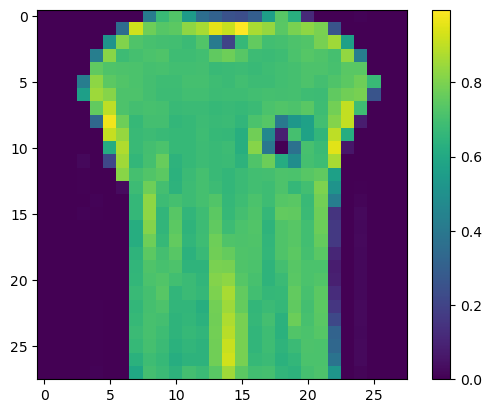

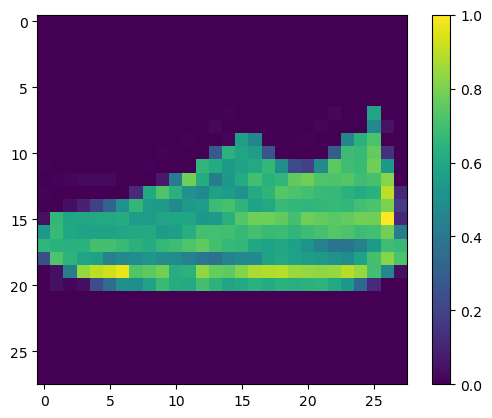

0.0


In [9]:
def show_image(image):
    plt.figure()
    plt.imshow(image)
    plt.colorbar()
    plt.grid(False)
    plt.show()

# array index
this_pair = 17

# show images at this index
show_image(ts_pairs[this_pair][0])
show_image(ts_pairs[this_pair][1])

# print the label for this pair
print(ts_y[this_pair])


(119980, 2, 28, 28)
(2, 28, 28)


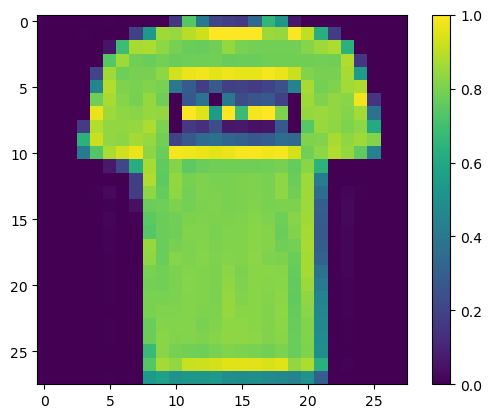

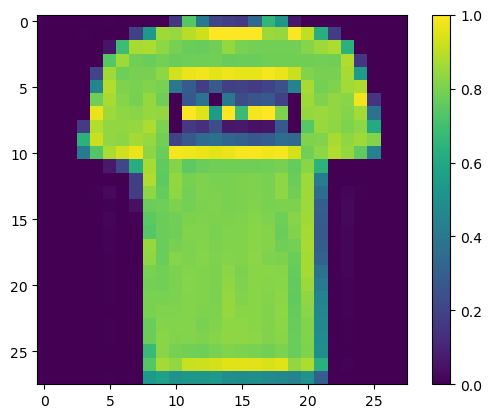

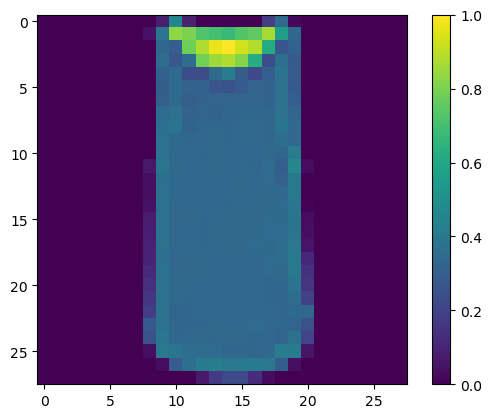

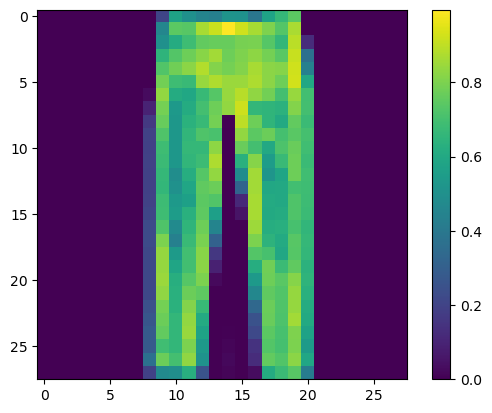

In [11]:
# print other pairs

print(tr_pairs.shape)
print((tr_pairs[ 0]).shape)

show_image(tr_pairs[:,0][0])
show_image(tr_pairs[:,0][1])

show_image(tr_pairs[:,1][0])
show_image(tr_pairs[:,1][1])

## Build the  base Model

Next, you'll define some utilities for building our model.

In [4]:
def initialize_base_network():
    input = Input(shape= (28,28,) , name = "base_input")
    x = Flatten(name = "flatten_input")(input)
    x = Dense(128, activation = 'relu', name= "first_base_dense")(x)
    x = Dropout(0.1, name = "first_dropout")(x)
    x = Dense(128, activation = 'relu', name = "second_base_dense")(x)
    x = Dropout(0.1, name = "second_dropout")(x)
    x = Dense(128, activation = 'relu', name = "third_base_dense")(x)
    return Model(inputs = input, outputs = x)


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

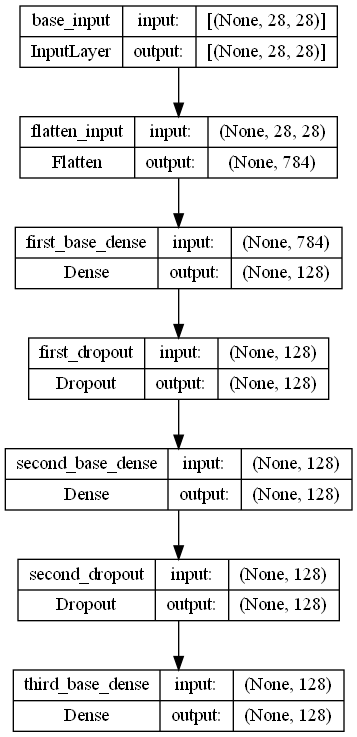

In [6]:
base_network = initialize_base_network()
plot_model(base_network, show_shapes=True, show_layer_names=True, to_file='base-model.png')

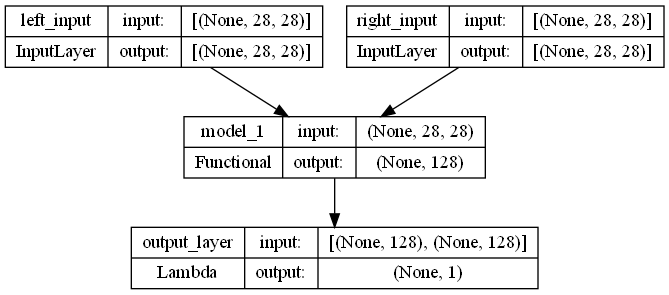

In [7]:
# create the left input and point to the base network
input_a = Input(shape=(28,28,), name = "left_input")
vect_output_a = base_network(input_a)

# create the right input and point to the base network
input_b = Input(shape=(28,28,), name="right_input")
vect_output_b = base_network(input_b)

# measure the similarity of the two vector outputs
output = Lambda(euclidean_distance, name = "output_layer",
                output_shape = eucl_dist_output_shape)([vect_output_a, vect_output_b])

# specify the inputs and output of the model
model = Model([input_a, input_b], output)

# plot model graph
plot_model(model, show_shapes = True, show_layer_names = True, to_file='outer-model.png')

# define the custom loss and training

In [8]:
def contrastive_loss_with_margin(margin):
    def contrastive_loss(y_true, y_pred):
        '''Contrastive loss from Hadsell-et-al.'06
        http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
        '''
        square_pred = K.square(y_pred)
        margin_square = K.square(K.maximum(margin - y_pred, 0))
        return K.mean(y_true * square_pred + (1 - y_true) * margin_square)
    return contrastive_loss

In [9]:
tr_pairs.shape

(119980, 2, 28, 28)

In [10]:
tr_pairs[:,0].shape, tr_pairs[:,1].shape # Left image and right image to fed to net 

((119980, 28, 28), (119980, 28, 28))

In [11]:
rms = RMSprop()
model.compile(loss= contrastive_loss_with_margin(margin=1), optimizer=rms)
history = model.fit([tr_pairs[:,0], tr_pairs[:,1]], tr_y, epochs=8, batch_size=64, validation_data=([ts_pairs[:,0], ts_pairs[:,1]], ts_y))

Epoch 1/8
1875/1875 [==============================] - 21s 10ms/step - loss: 0.1070 - val_loss: 0.0825
Epoch 2/8
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0798 - val_loss: 0.0718
Epoch 3/8
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0712 - val_loss: 0.0712
Epoch 4/8
1875/1875 [==============================] - 25s 13ms/step - loss: 0.0678 - val_loss: 0.0694
Epoch 5/8
1875/1875 [==============================] - 20s 11ms/step - loss: 0.0655 - val_loss: 0.0668
Epoch 6/8
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0643 - val_loss: 0.0665
Epoch 7/8
1875/1875 [==============================] - 24s 13ms/step - loss: 0.0628 - val_loss: 0.0675
Epoch 8/8
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0616 - val_loss: 0.0656


In [12]:
def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5    # returns a true and false array with using treshold 
    return np.mean(pred == y_true)   # compare trues in pred and 1s in y_true 

In [13]:
ts_y.shape

(19980,)

In [14]:
ts_y

array([1., 0., 1., ..., 0., 1., 0.], dtype=float32)

In [20]:
tf.compat.v1.reset_default_graph()

In [21]:
loss = model.evaluate(x = [ts_pairs[:,0], ts_pairs[:,1]], y = ts_y)

y_pred_train = model.predict([tr_pairs[:,0], tr_pairs[:,1]])
train_accuracy = compute_accuracy(tr_y, y_pred_train)

y_pred_test = model.predict([ts_pairs[:,0], ts_pairs[:,1]])
test_accuracy = compute_accuracy(ts_y, y_pred_test)

print("Loss = {}, Train Accuracy = {} Test Accuracy = {}".format(loss, train_accuracy, test_accuracy))

625/625 [==============================] - 1s 2ms/step
Loss = 0.06561069935560226, Train Accuracy = 0.9255292548758126 Test Accuracy = 0.9108608608608608


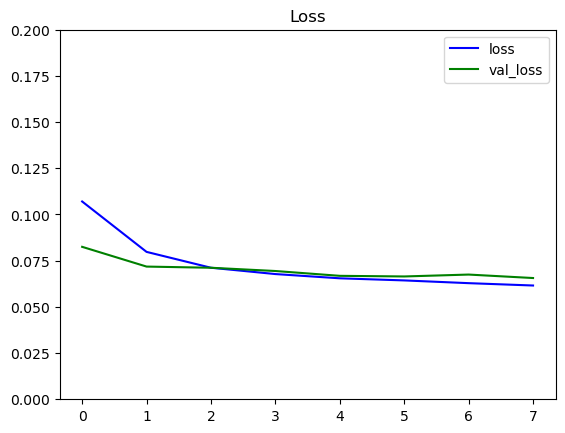

In [22]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)
    plt.legend()

plot_metrics(metric_name='loss', title="Loss", ylim=0.2)

In [23]:
# Matplotlib config
def visualize_images():
    plt.rc('image', cmap='gray_r')
    plt.rc('grid', linewidth=0)
    plt.rc('xtick', top=False, bottom=False, labelsize='large')
    plt.rc('ytick', left=False, right=False, labelsize='large')
    plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
    plt.rc('text', color='a8151a')
    plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts

# utility to display a row of digits with their predictions
def display_images(left, right, predictions, labels, title, n):
    plt.figure(figsize=(17,3))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    plt.grid(None)
    left = np.reshape(left, [n, 28, 28])
    left = np.swapaxes(left, 0, 1)
    left = np.reshape(left, [28, 28*n])
    plt.imshow(left)
    plt.figure(figsize=(17,3))
    plt.yticks([])
    plt.xticks([28*x+14 for x in range(n)], predictions)
    for i,t in enumerate(plt.gca().xaxis.get_ticklabels()):
        if predictions[i] > 0.5: t.set_color('red') # bad predictions in red
    plt.grid(None)
    right = np.reshape(right, [n, 28, 28])
    right = np.swapaxes(right, 0, 1)
    right = np.reshape(right, [28, 28*n])
    plt.imshow(right)

In [24]:
y_pred_train.shape 

(119980, 1)

array([110499,  64829,  39598,  71352, 117548, 101274,  60650, 105709,
        15508,  64057])

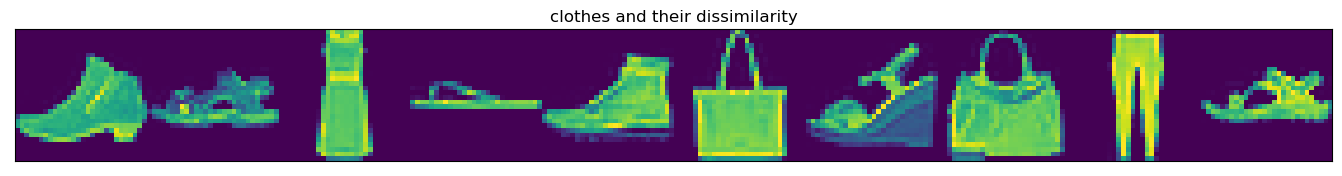

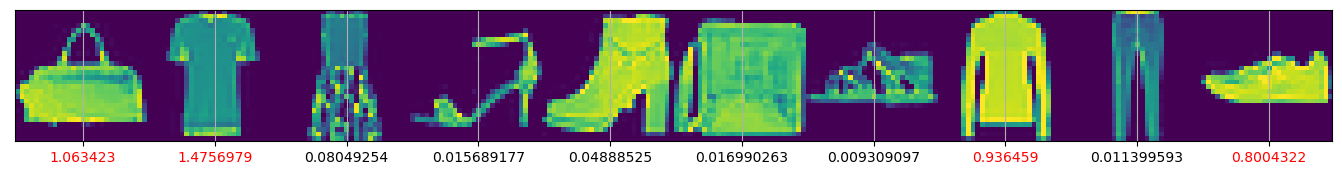

In [25]:
y_pred_train = np.squeeze(y_pred_train)  # Remove axes of length one from a.
indexes = np.random.choice(len(y_pred_train), size =10)# 10 random nums between 0 and 119980
display_images(tr_pairs[:, 0][indexes], tr_pairs[:, 1][indexes], y_pred_train[indexes], tr_y[indexes], "clothes and their dissimilarity", 10)

indexes